In [26]:
# import necessary libraries
import sys, warnings, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from math import sqrt

from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn import preprocessing

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from scipy.stats import pearsonr as r
import MDAnalysis as mda

import nglview as nv ## probably need to install

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 10]

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [27]:
def sigma(x):
    # define sigma function to map [-inf, +inf] to [0,1] 
    return (np.exp(x)) / (1 + np.exp(x))
    
def logit(x):
    # define logit function to map [0,1] to [-inf, +inf] 
    return np.log(x/(1-x))


In [28]:
# load pandas DataFrame with activity, MM-PBSA and MM-GBSA data 
# separate data to a train and a test set 

data = pd.read_csv("mutants.csv")

train = data.loc[((data['mutant'] == 'WT')  | 
                  (data['mutant'] == 'Y24F') | 
                  (data['mutant'] == 'F65A') | 
                  (data['mutant'] == 'N171A') | 
                  (data['mutant'] == 'Q257A') | 
                  (data['mutant'] == 'E270A') | 
                  (data['mutant'] == 'Q257A_E270A') | 
                  (data['mutant'] == 'L20W') | 
                  (data['mutant'] == 'A58F') | 
                  (data['mutant'] == 'A58M') | 
                  (data['mutant'] == 'F130V') | 
                  (data['mutant'] == 'A137S') | 
                  (data['mutant'] == 'N262A') | 
                  (data['mutant'] == 'N262T')), :]

test = data.loc[(#(data['mutant'] == 'T208A')  | 
                 (data['mutant'] == 'R224A')  | 
                 (data['mutant'] == 'L134Q')),  :]

In [29]:
# get residues within 5. Angstrom of the substrate
u = mda.Universe("LsBSH_WT_tca_trans.pdb") 
res = u.select_atoms("(around 5 resname CTC) and protein").residues
descs_around = ["ge" + str(i._ix-1) for i in res][1:] + ["gv" + str(i._ix-1) for i in res][1:]

In [30]:
# select the previously calculated GBSA and PBSA descriptors from the data file based on the surrounding residues
desc_train = train[descs_around]
desc_test = test[descs_around]

# since most of the amino acid residues do not interact with the substrate so let us 
# select descriptors with reasonable variance
selected_train = desc_train.loc[:, desc_train.std() > .05]
selected_test = desc_test.loc[:, desc_train.std() > .05]
print("Shape of the descriptor matrices:")
print("Train: " + str(selected_train.shape))
print("Test: " + str(selected_test.shape))


Shape of the descriptor matrices:
Train: (220, 57)
Test: (34, 57)


In [31]:
# apply logit transform of the dependent variable to be able to use the linear output
# since the zero activity values cannot be used directly for this transform let us small but non-zero value instead
train.loc[train['activity'] == 0.0, 'activity'] = 0.05
test.loc[test['activity'] == 0.0, 'activity'] = 0.05
y = logit(train.activity)
y_t = logit(test.activity)

# uncomment to scramble the dependent variable 
#y = y.sample(frac = 1).reset_index(drop = True)
#y_t = y_t.sample(frac = 1).reset_index(drop = True)

In [32]:
# setup grid and cv objects for cross-validation and specify reproducible CV object
grid = {'alpha': np.logspace(-5, 2, 100)}
CV = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 42)

In [33]:
# Initally we build a lasso regression model

model_lasso = Lasso()

search_lasso = GridSearchCV(model_lasso, grid, scoring = 'neg_mean_absolute_error',
                                 refit= True, verbose = 0, cv = CV, n_jobs = -1)

results_lasso = search_lasso.fit(selected_train, y)

In [34]:
# get the best parameter for the penalty and the respective model
print("Best alpha for MM-GBSA descriptor set (lasso): ", results_lasso.best_params_['alpha'])

lasso_best_estimator = results_lasso.best_estimator_

Best alpha for MM-GBSA descriptor set (lasso):  0.01519911082952933


In [35]:
# redo cross-validation to get all prediction parameters for the particular parameters 
# MM-GBSA

# define two lists to keep predicted and actual activity values 
y_accum_lasso = []        # 
y_test_accum_lasso = []   # 

for train_index, test_index in CV.split(selected_train.values):
    # get train and test data for the current fold
    X_train, X_test = selected_train.values[train_index], selected_train.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    # train model with the predefined parameters
    model_lasso = lasso_best_estimator.fit(X_train, y_train)
    y_accum_lasso.extend(list(y_test))
    y_test_accum_lasso.extend(list(model_lasso.predict(X_test)))

# fit the model with all data to get the prediction for the external test set
model_lasso = lasso_best_estimator.fit(selected_train, y)
y_t_lasso = model_lasso.predict(selected_test)

print("Best Lasso model: ") 
print("R2cv = ", R2(y_accum_lasso, y_test_accum_lasso))
print("MAE = ", MAE(sigma(y_accum_lasso), sigma(y_test_accum_lasso))) 
print("RMSE = ", sqrt(MSE(sigma(y_accum_lasso), sigma(y_test_accum_lasso))))
print("MAE_test = ", MAE(sigma(y_t), sigma(y_t_lasso)))
print("RMSE_test = ", sqrt(MSE(sigma(y_t), sigma(y_t_lasso))))
print("Q^2 = ", R2(y_t, y_t_lasso))

Best Lasso model: 
R2cv =  0.666779955884302
MAE =  0.15787944232318493
RMSE =  0.2331276443762856
MAE_test =  0.1650784928639525
RMSE_test =  0.23295073858148732
Q^2 =  0.3434939099621197


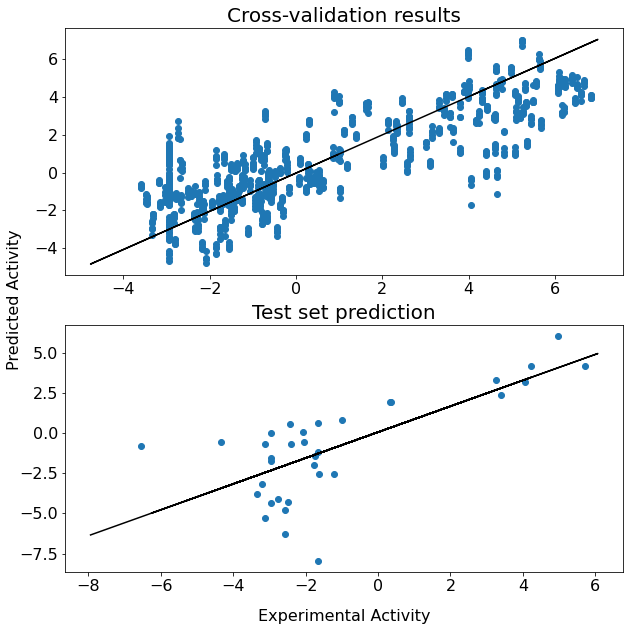

In [36]:
# Plot CV results for the train and R^2 for the test set for the Lasso model

figure, ax = plt.subplots(2)

# train CV
ax[0].plot(y_accum_lasso, y_test_accum_lasso, 'o')
m, b = np.polyfit(y_test_accum_lasso, y_accum_lasso, 1)
ax[0].plot(np.array(y_test_accum_lasso), m * np.array(y_test_accum_lasso) + b, color="black")
ax[0].set_title('Cross-validation results', fontsize = 20)
ax[0].tick_params(axis = 'x', labelsize = 16)
ax[0].tick_params(axis = 'y', labelsize = 16)

# test
ax[1].plot(y_t, y_t_lasso, 'o')
m, b = np.polyfit(y_t, y_t_lasso, 1)
ax[1].plot(np.array(y_t_lasso), m * np.array(y_t_lasso) + b, color="black")
ax[1].set_title('Test set prediction', fontsize = 20)
ax[1].tick_params(axis = 'x', labelsize = 16)
ax[1].tick_params(axis = 'y', labelsize = 16)


figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Experimental Activity', labelpad=20, fontsize =16)
plt.ylabel('Predicted Activity', labelpad=20, fontsize =16)


plt.show()

In [37]:
# Lasso regression is used here for variable selection 
# select descriptors with non-zero coefficients

selected_afterLasso_train = selected_train.loc[:, model_lasso.coef_ != 0.]
selected_afterLasso_test = selected_test.loc[:, model_lasso.coef_ != 0.]

# Lasso model has made many coefficients to zero
print("The change in descriptor matrix shape after lasso:")
print("Train: ", str(selected_train.shape), " -> ", str(selected_afterLasso_test.shape))

The change in descriptor matrix shape after lasso:
Train:  (220, 57)  ->  (34, 24)


In [38]:
# We use the obtained by lasso descriptors to fit ridge regression model

model_ridge = Ridge()

search_ridge = GridSearchCV(model_ridge, grid, scoring = 'neg_mean_absolute_error',
                                 refit= True, verbose = 0, cv = CV, n_jobs = -1)

results_ridge = search_ridge.fit(selected_afterLasso_train, y)

In [39]:
# get the best parameter for the penalty and the respective model
print("Best alpha for Ridge regression: ", results_ridge.best_params_['alpha'])

ridge_best_estimator = results_ridge.best_estimator_

Best alpha for Ridge regression:  0.46415888336127725


In [40]:
# redo cross-validation to get all prediction parameters for the particular parameters (ridge)
# define two lists to keep predicted and actual activity values 

y_accum_ridge = []        #  
y_test_accum_ridge = []   # 

for train_index, test_index in CV.split(selected_afterLasso_train.values):
    # get train and test data for the current fold
    X_train, X_test = selected_afterLasso_train.values[train_index], selected_afterLasso_train.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    # train model with the predefined parameters
    model_ridge = ridge_best_estimator.fit(X_train, y_train)
    y_accum_ridge.extend(list(y_test))
    y_test_accum_ridge.extend(list(model_ridge.predict(X_test)))

# fit the model with all data to get the prediction for the external test set
model_ridge = ridge_best_estimator.fit(selected_afterLasso_train, y)
y_t_ridge = model_ridge.predict(selected_afterLasso_test)

print("Best Ridge model: ") 
print("R2cv = ", R2(y_accum_ridge, y_test_accum_ridge))
print("MAE = ", MAE(sigma(y_accum_ridge), sigma(y_test_accum_ridge))) 
print("RMSE = ", sqrt(MSE(sigma(y_accum_ridge), sigma(y_test_accum_ridge))))
print("MAE_test = ", MAE(sigma(y_t), sigma(y_t_ridge)))
print("RMSE_test = ", sqrt(MSE(sigma(y_t), sigma(y_t_ridge))))
print("Q^2 = ", R2(y_t, y_t_ridge))

Best Ridge model: 
R2cv =  0.6813005786915137
MAE =  0.15332197688500895
RMSE =  0.22595449097438677
MAE_test =  0.15840840557880467
RMSE_test =  0.2360383433735278
Q^2 =  0.34763325286162694


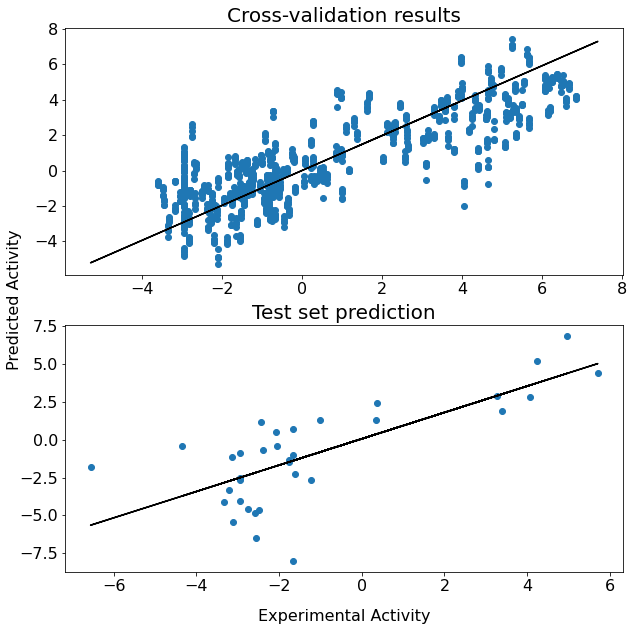

In [41]:
# Plot CV results for the train and R^2 for the test set for the Ridge model

figure, ax = plt.subplots(2)

# train CV
ax[0].plot(y_accum_ridge, y_test_accum_ridge, 'o')
m, b = np.polyfit(y_test_accum_ridge, y_accum_ridge, 1)
ax[0].plot(np.array(y_test_accum_ridge), m * np.array(y_test_accum_ridge) + b, color="black")
ax[0].set_title('Cross-validation results', fontsize = 20)
ax[0].tick_params(axis = 'x', labelsize = 16)
ax[0].tick_params(axis = 'y', labelsize = 16)

# test
ax[1].plot(y_t, y_t_ridge, 'o')
m, b = np.polyfit(y_t, y_t_ridge, 1)
ax[1].plot(np.array(y_t), m * np.array(y_t) + b, color="black")
ax[1].set_title('Test set prediction', fontsize = 20)
ax[1].tick_params(axis = 'x', labelsize = 16)
ax[1].tick_params(axis = 'y', labelsize = 16)


figure.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Experimental Activity', labelpad=20, fontsize = 16)
plt.ylabel('Predicted Activity', labelpad=20, fontsize = 16)

#figure.savefig("train_test.png")
plt.show()


In [42]:
# Let's visualize the binding site with the coefficients for each amino acid

# scale descriptors to
min_max_scaler = preprocessing.MinMaxScaler()
selected_afterLasso_train = pd.DataFrame(min_max_scaler.fit_transform(selected_afterLasso_train), columns = selected_afterLasso_train.columns)
selected_afterLasso_test = pd.DataFrame(min_max_scaler.transform(selected_afterLasso_test), columns = selected_afterLasso_test.columns)

# Since we have plausible intermolecular contacts at low interaction energies 
# plausible interactions will be observed with descriptors values close to 0
# It seem a little wierd so we intend to make favourable interactions to be close to 1 while unfavourable close to 0
selected_afterLasso_train = 1 - selected_afterLasso_train

model_ridge = ridge_best_estimator.fit(1 - selected_afterLasso_train.values, y)

view_el = nv.show_structure_file("LsBSH_WT_tca_trans.pdb")
view_el.add_cartoon("protein", color = 'white')
view_el.add_ball_and_stick("2:A")

view_vdw = nv.show_structure_file("LsBSH_WT_tca_trans.pdb")
view_vdw.add_cartoon("protein", color = 'white')
view_vdw.add_ball_and_stick("2:A")

max_coef = max(list(model_ridge.coef_))

for aa, coef in zip(list(selected_afterLasso_train.columns), list(filter(None, model_ridge.coef_))):
    if aa[1] == 'e':
        if coef > 0:
            # decide whether residues are from the chain A or ther other chain
            if int(aa[2:]) < 323:
                view_el.add_line(str(int(aa[2:]) + 3) + ":A", linewidth = 0.3 + abs(coef)/max_coef*5., color = "red")       
            else:
                view_el.add_line(str(int(aa[2:]) % 323 + 3) + ":D", linewidth = 0.3 + abs(coef)/max_coef*5., color = "red")
        else:
            if int(aa[2:]) < 323:
                view_el.add_line(str(int(aa[2:]) + 3) + ":A", linewidth = 0.3 + abs(coef)/max_coef*5., color = "blue")
            else:
                view_el.add_line(str(int(aa[2:]) % 323 + 3) + ":D", linewidth = 0.3 + abs(coef)/max_coef*5., color = "blue")

    if aa[1] == 'v':
        if coef > 0:
            # decide whether residues are from the chain A or ther other chain
            if int(aa[2:]) < 323:
                view_vdw.add_line(str(int(aa[2:]) + 3) + ":A", linewidth = 0.3 + abs(coef)/max_coef*5., color = "red")       
            else:
                view_vdw.add_line(str(int(aa[2:]) % 323 + 3) + ":D", linewidth = 0.3 + abs(coef)/max_coef*5., color = "red")
        else:
            if int(aa[2:]) < 323:
                view_vdw.add_line(str(int(aa[2:]) + 3) + ":A", linewidth = 0.3 + abs(coef)/max_coef*5., color = "blue")
            else:
                view_vdw.add_line(str(int(aa[2:]) % 323 + 3) + ":D", linewidth = 0.3 + abs(coef)/max_coef*5., color = "blue")    
    


In [43]:
# Red color means favourable contributions to hydrolysis rate
# Blue - unfavourable

In [44]:
view_el

NGLWidget()

In [45]:
view_vdw

NGLWidget()